### The German Traffic Sign Benchmark

Student Name 1: ...

Student Name 2: ...

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [1]:
!wget -c http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
!unzip FullIJCNN2013.zip

--2019-04-06 18:51:22--  http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
Resolving benchmark.ini.rub.de (benchmark.ini.rub.de)... 134.147.122.15
Connecting to benchmark.ini.rub.de (benchmark.ini.rub.de)|134.147.122.15|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  FullIJCNN2013.zip
replace FullIJCNN2013/00000.ppm? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (224, 224)#(224, 224)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [0]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

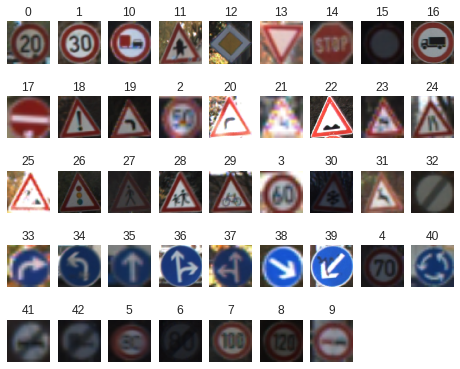

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

Using TensorFlow backend.


In [0]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

## Assignment 3.3: Transfer learning

<h3>ResNet50</h3>

In [0]:
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, MaxPooling2D, BatchNormalization, Activation, Flatten
from keras.models import Model

#baseline = ResNet50(include_top = True, weights='imagenet', input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3))

#x = baseline.output
#x = MaxPooling2D()(x)
#x = Dense(512, activation = 'relu')(x)

baseline = ResNet50(weights='imagenet', input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3))
predictions = Dense(num_classes, activation='softmax')(baseline.layers[-2].output)


#predictions = Dense(num_classes, activation='softmax')#(x)
model = Model(inputs=baseline.input, outputs=predictions)

In [10]:
# overview of layers, to decide which ones to train
for i,layer in enumerate(model.layers):
    print(i,layer.name,layer.trainable)

0 input_2 False
1 conv1_pad True
2 conv1 True
3 bn_conv1 True
4 activation_50 True
5 pool1_pad True
6 max_pooling2d_2 True
7 res2a_branch2a True
8 bn2a_branch2a True
9 activation_51 True
10 res2a_branch2b True
11 bn2a_branch2b True
12 activation_52 True
13 res2a_branch2c True
14 res2a_branch1 True
15 bn2a_branch2c True
16 bn2a_branch1 True
17 add_17 True
18 activation_53 True
19 res2b_branch2a True
20 bn2b_branch2a True
21 activation_54 True
22 res2b_branch2b True
23 bn2b_branch2b True
24 activation_55 True
25 res2b_branch2c True
26 bn2b_branch2c True
27 add_18 True
28 activation_56 True
29 res2c_branch2a True
30 bn2c_branch2a True
31 activation_57 True
32 res2c_branch2b True
33 bn2c_branch2b True
34 activation_58 True
35 res2c_branch2c True
36 bn2c_branch2c True
37 add_19 True
38 activation_59 True
39 res3a_branch2a True
40 bn3a_branch2a True
41 activation_60 True
42 res3a_branch2b True
43 bn3a_branch2b True
44 activation_61 True
45 res3a_branch2c True
46 res3a_branch1 True
47 bn3a_br

In [11]:
# set them to be trained
for layer in model.layers[:160]:
    layer.trainable=False
for layer in model.layers[171:]:
    print("Trainable: ",layer.name)
    layer.trainable=True



Trainable:  res5c_branch2c
Trainable:  bn5c_branch2c
Trainable:  add_32
Trainable:  activation_98
Trainable:  avg_pool
Trainable:  dense_3


In [12]:
from keras.optimizers import Adam, SGD, Adadelta

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#opt = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
#opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

<h2>Training part</h2>

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, fill_mode='nearest')
datagen.fit(tr_signs, augment=True)

In [14]:
train_steps = int(len(tr_signs) / 16)
valid_steps = int(len(va_signs) / 16)
data = model.fit_generator(datagen.flow(tr_signs, tr_labels, batch_size=16), epochs=100, steps_per_epoch=train_steps, verbose=2, validation_data=(va_signs, va_labels), validation_steps=valid_steps, callbacks=[tensorboard])

start = time()
loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('Model took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 13s - loss: 2.9080 - acc: 0.3277 - val_loss: 3.8891 - val_acc: 0.0238
Epoch 2/100
 - 9s - loss: 1.3255 - acc: 0.6387 - val_loss: 3.9319 - val_acc: 0.0595
Epoch 3/100
 - 9s - loss: 0.9346 - acc: 0.7314 - val_loss: 3.8711 - val_acc: 0.0595
Epoch 4/100
 - 9s - loss: 0.8018 - acc: 0.7737 - val_loss: 3.9375 - val_acc: 0.0119
Epoch 5/100
 - 9s - loss: 0.6866 - acc: 0.7856 - val_loss: 3.8781 - val_acc: 0.0238
Epoch 6/100
 - 9s - loss: 0.5501 - acc: 0.8311 - val_loss: 3.8478 - val_acc: 0.0516
Epoch 7/100
 - 9s - loss: 0.4682 - acc: 0.8632 - val_loss: 3.8541 - val_acc: 0.0516
Epoch 8/100
 - 9s - loss: 0.4492 - acc: 0.8683 - val_loss: 3.8056 - val_acc: 0.0595
Epoch 9/100
 - 9s - loss: 0.3456 - acc: 0.8953 - val_loss: 3.7887 - val_acc: 0.0595
Epoch 10/100
 - 9s - loss: 0.4003 - acc: 0.8767 - val_loss: 3.8028 - val_acc: 0.0595
Epoch 11/100
 - 9s - loss: 0.3098 - acc: 0.9037 - val_loss: 3.7609 - val_acc: 0.0595
Epoch 12/100
 - 9s - loss

KeyboardInterrupt: ignored